In [6]:
# ==========================================
# 1. DATENVORBEREITUNG
# ==========================================
# (Angenommen, dein DataFrame heißt df und wurde bereits eingelesen, 
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. DATENVORBEREITUNG (für alle Schadstoffe)
# ==========================================
# (Angenommen, dein DataFrame heißt 'df')

# Mapping der Spaltennamen anwenden
rename_dict = {
    "Stationscode": "code",
    "Stationsname": "name",
    "Stationsumgebung": "area",
    "Art der Station": "type",
    "Timestamp": "timestamp",
    "Einheit": "unit",
    "Feinstaub (PM₁₀)": "pm10",
    "Feinstaub (PM₂,₅)": "pm25",
    "Kohlenmonoxid (CO)": "co",
    "Ozon (O₃)": "o3",
    "Schwefeldioxid (SO₂)": "so2",
    "Stickstoffdioxid (NO₂)": "no2"
}

# Ggf. Pfad zur Datei anpassen
data_path = Path.cwd() / "Luftqualitaet_Zusammenfassung.csv"
#data_path = Path.cwd() / "raw_data_2" / "Luftqualitaet_Zusammenfassung.csv"

df = pd.read_csv(data_path, encoding="UTF-8", sep=";")

# Benenne die Spalten im DataFrame um
df.rename(columns=rename_dict, inplace=True)

# Stelle sicher, dass timestamp ein Datetime-Objekt ist
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["time"] = df["timestamp"].dt.time
df["date"] = df["timestamp"].dt.date

# Definiere deine Schadstoff-Spalten (jetzt inklusive 'co')
pollutant_cols = ["pm10", "pm25", "co", "o3", "so2", "no2"]

df = df.drop(columns=["co"])

# to numeric, coerce errors to NaN
pollutant_cols = ["pm10", "pm25", "o3", "so2", "no2"]
for col in pollutant_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


# Mappe die Monatszahlen auf echte Monatsnamen
monatsnamen = {
    1: "Januar", 2: "Februar", 3: "März", 4: "April", 
    5: "Mai", 6: "Juni", 7: "Juli", 8: "August", 
    9: "September", 10: "Oktober", 11: "November", 12: "Dezember"
}



/var/folders/1y/b928j3z917s1tz2f3wl_3m5r0000gn/T/ipykernel_2216/3652661390.py:36: DtypeWarning: Columns (0: Feinstaub (PM₂,₅), 1: Kohlenmonoxid (CO), 2: Ozon (O₃), 3: Schwefeldioxid (SO₂)) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, encoding="UTF-8", sep=";")


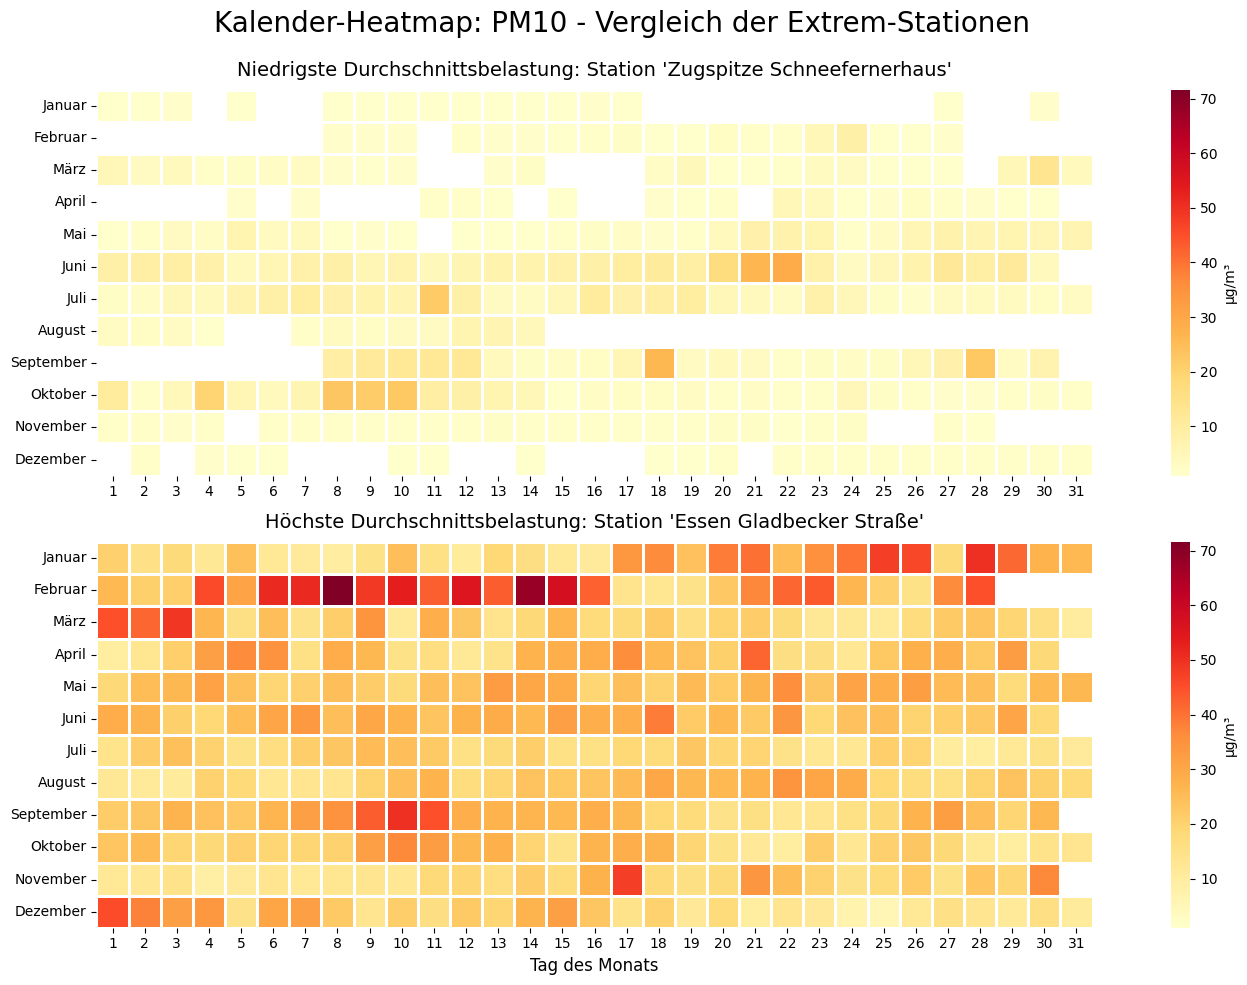

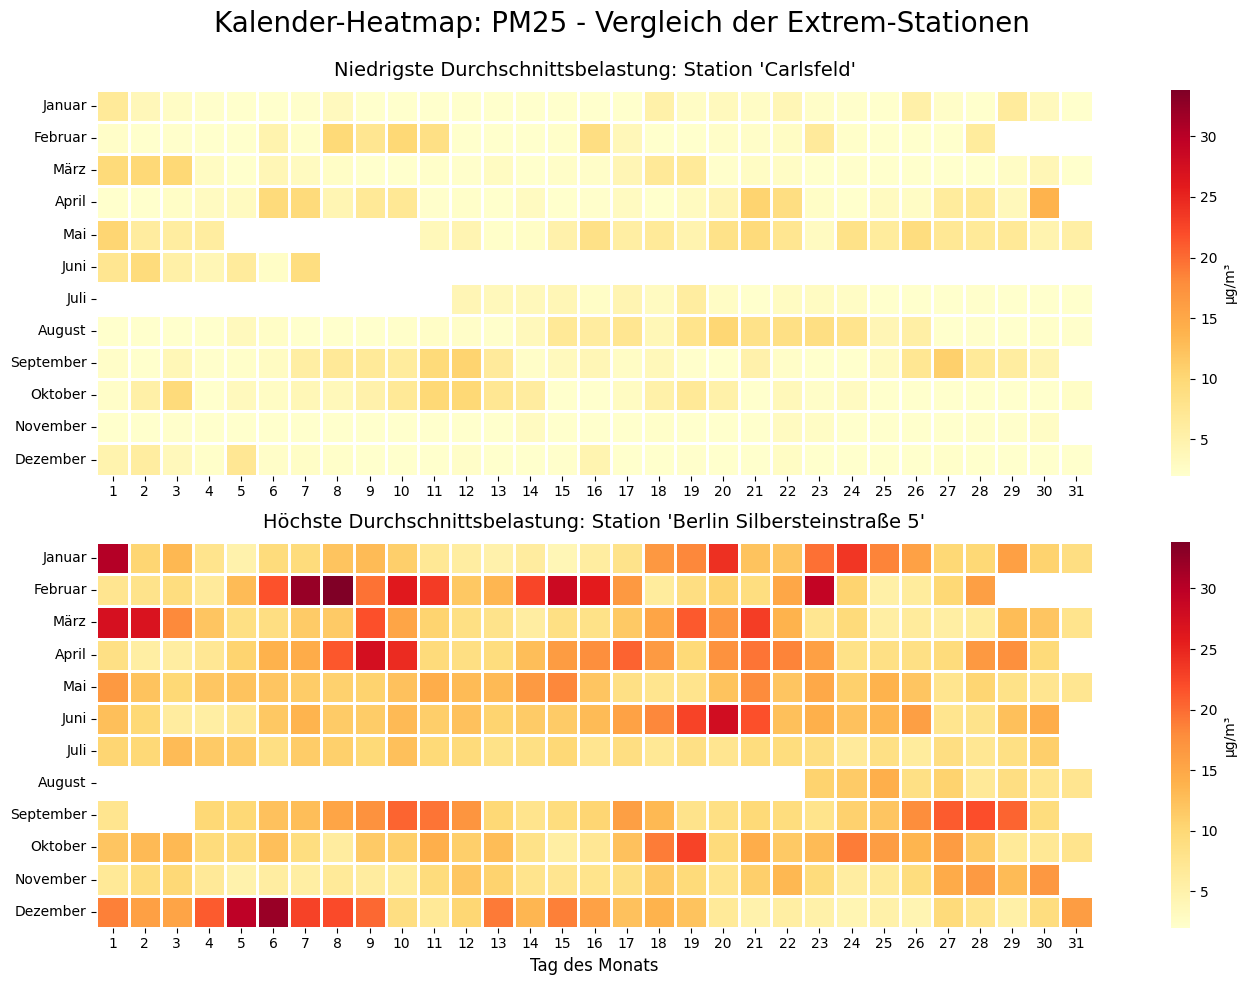

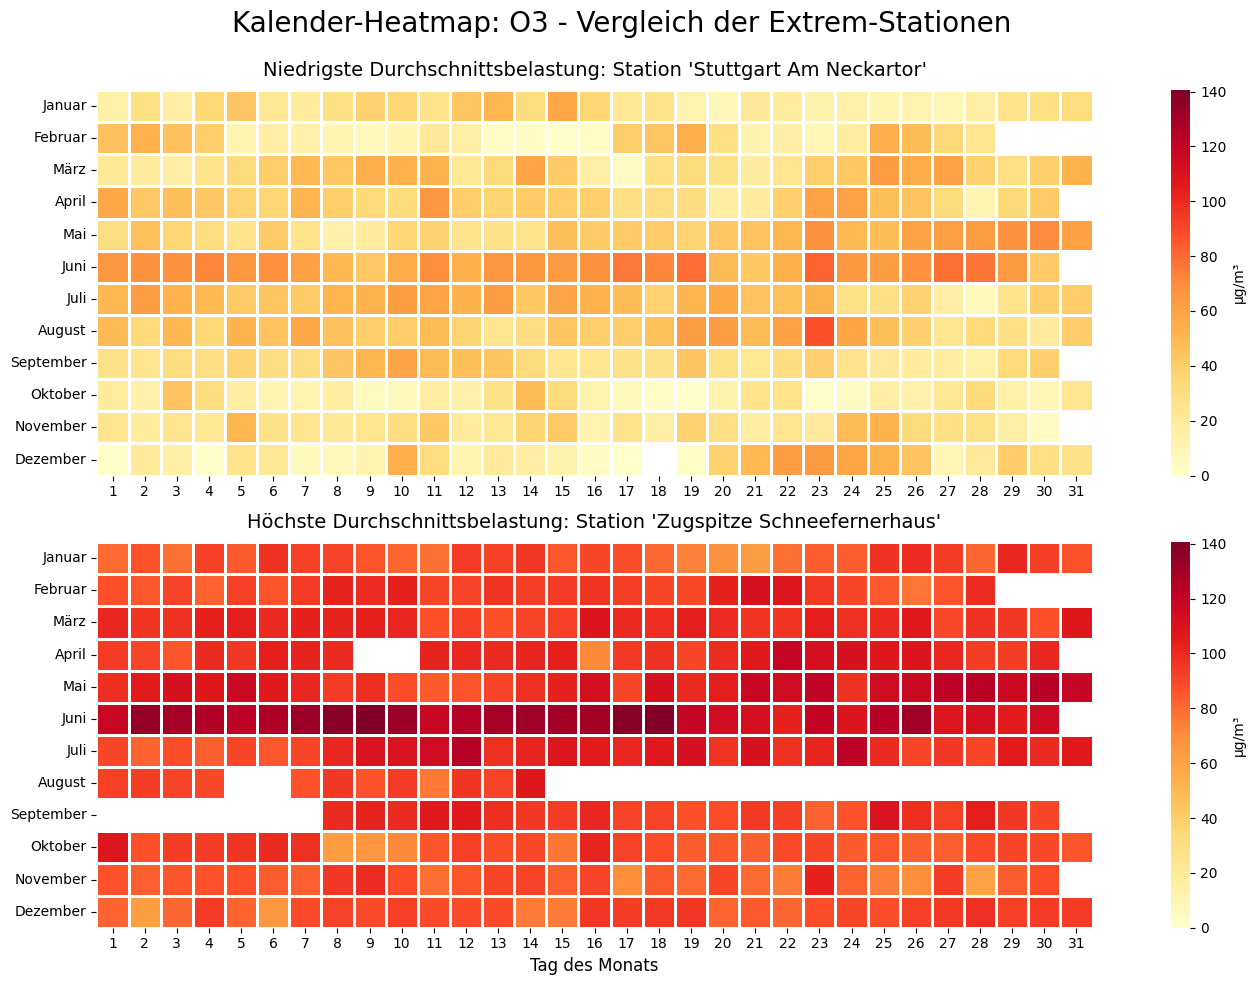

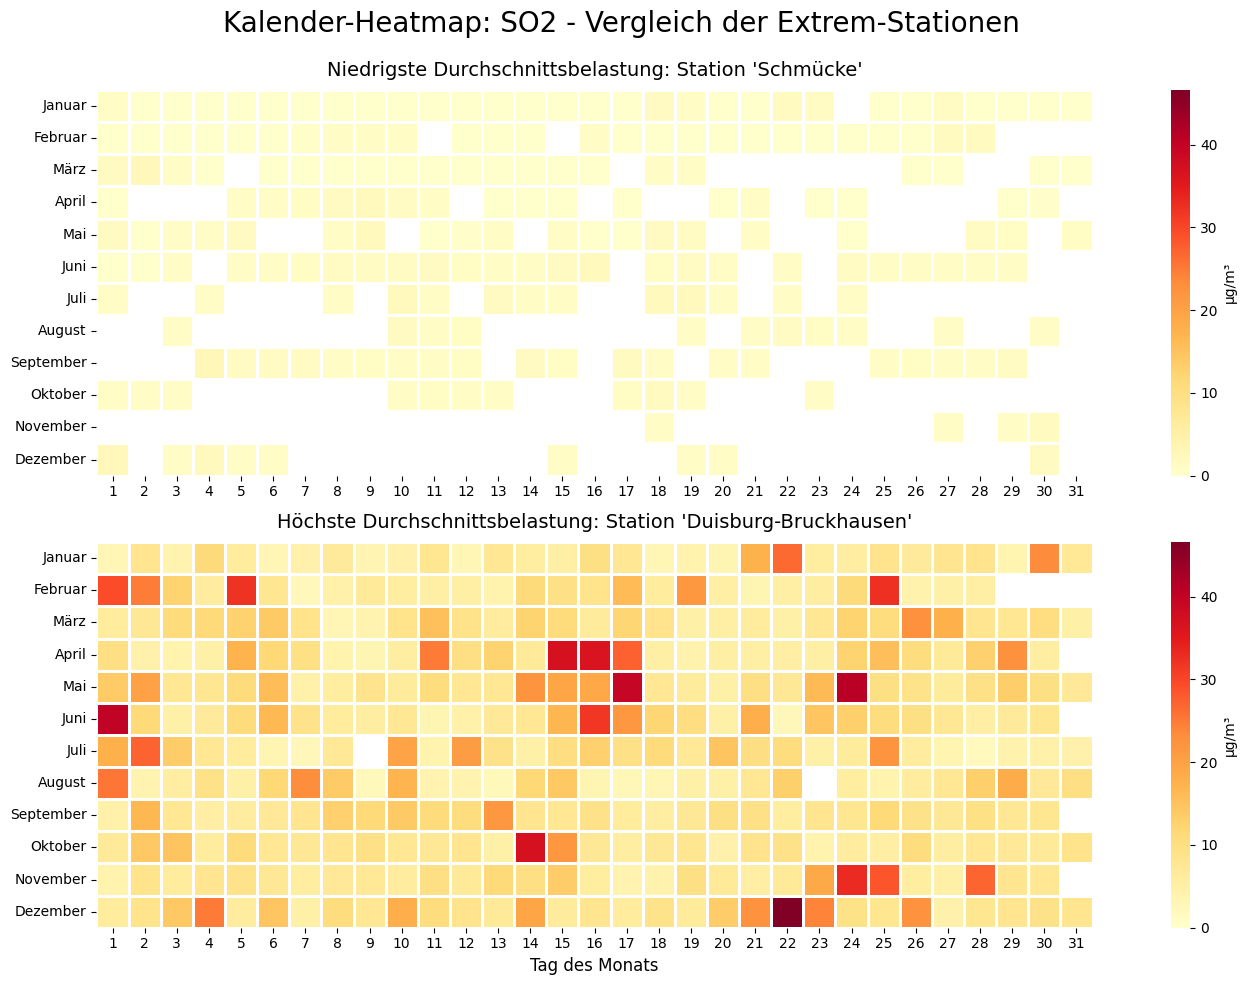

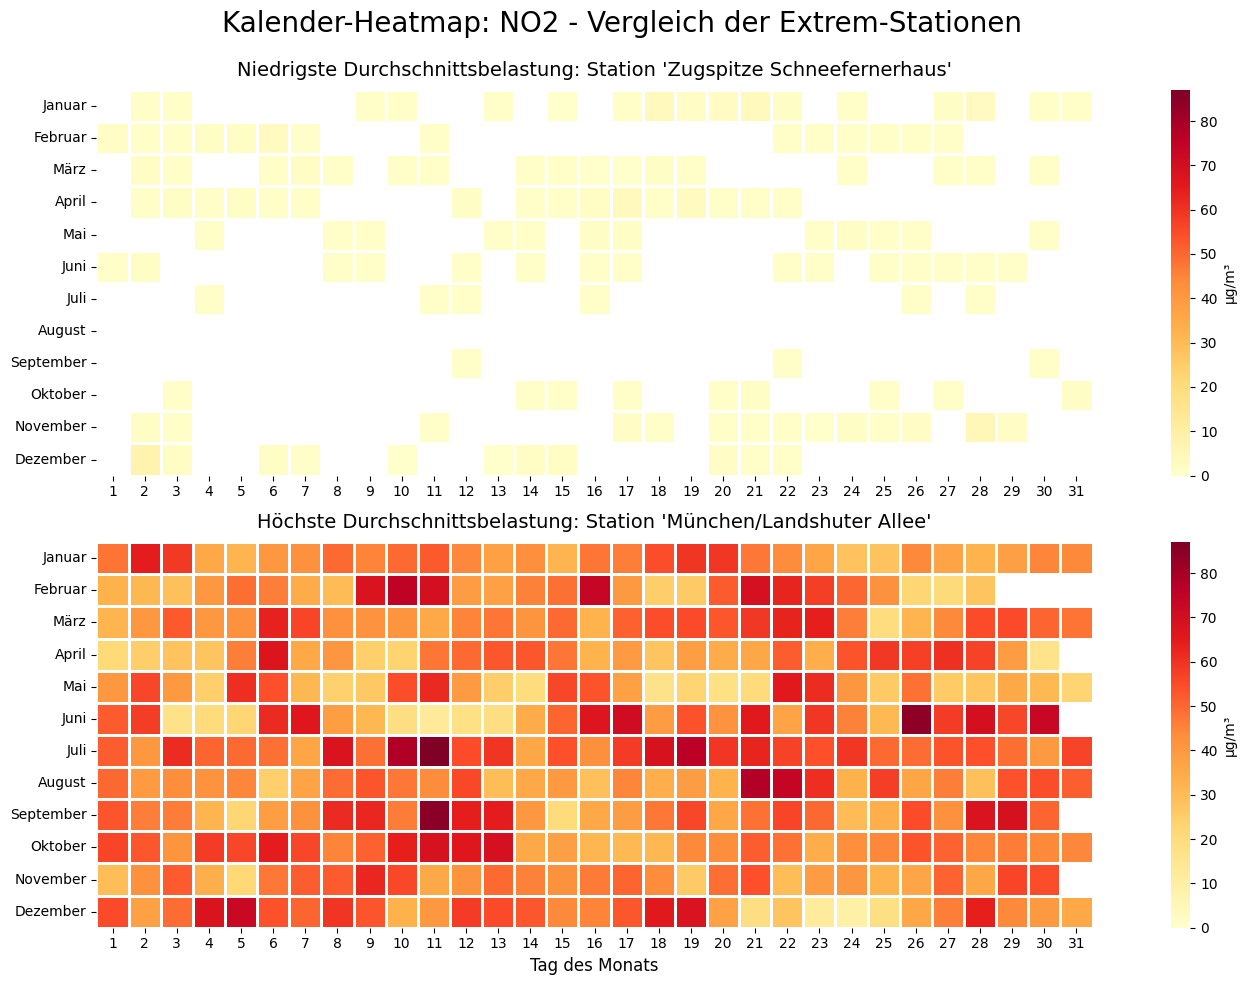

In [7]:

# ==========================================
# 2. SCHLEIFE FÜR DIE EXTREM-STATIONEN
# ==========================================
for pollutant in pollutant_cols:
    
    # 1. Filtere leere Daten heraus
    if df[pollutant].isna().all():
        print(f"⚠️ Überspringe {pollutant.upper()}: Keine Daten.")
        continue
        
    # 2. Finde die Station mit dem höchsten und dem niedrigsten Jahresdurchschnitt
    annual_means = df.groupby("name")[pollutant].mean()
    
    station_min = annual_means.idxmin() # Name der Station mit dem niedrigsten Wert
    station_max = annual_means.idxmax() # Name der Station mit dem höchsten Wert
    
    # 3. Filtere das DataFrame auf genau diese beiden Stationen
    df_filtered = df[df["name"].isin([station_min, station_max])].copy()
    
    # 4. Berechne die Tagesmittelwerte für diese beiden Stationen
    daily_data = df_filtered.groupby([df_filtered["timestamp"].dt.date, "name"])[pollutant].mean().reset_index()
    daily_data.rename(columns={"timestamp": "Datum"}, inplace=True)
    daily_data["Datum"] = pd.to_datetime(daily_data["Datum"])
    
    daily_data["Monat"] = daily_data["Datum"].dt.month
    daily_data["Tag"] = daily_data["Datum"].dt.day
    
    # 5. Erstelle separate Pivot-Tabellen für beide Stationen
    data_min = daily_data[daily_data["name"] == station_min].pivot(index="Monat", columns="Tag", values=pollutant)
    data_max = daily_data[daily_data["name"] == station_max].pivot(index="Monat", columns="Tag", values=pollutant)
    
    # 6. Zwinge das Raster auf exakt 12 Monate und 31 Tage (damit der Kalender immer gleich aussieht, auch wenn Tage fehlen)
    data_min = data_min.reindex(index=range(1, 13), columns=range(1, 32))
    data_max = data_max.reindex(index=range(1, 13), columns=range(1, 32))
    
    # Setze die Monatsnamen
    data_min.index = data_min.index.map(monatsnamen)
    data_max.index = data_max.index.map(monatsnamen)
    
    # 7. Ermittle das absolute Minimum und Maximum für eine einheitliche Farbskala
    global_min = min(data_min.min().min(), data_max.min().min())
    global_max = max(data_min.max().max(), data_max.max().max())


    # ==========================================
    # 3. GRAFIK ERSTELLEN (2 Subplots untereinander)
    # ==========================================
    # Erstelle eine Figur mit 2 Zeilen und 1 Spalte
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))
    fig.suptitle(f"Kalender-Heatmap: {pollutant.upper()} - Vergleich der Extrem-Stationen", fontsize=20, y=0.98)

    # --- Oberer Plot: Niedrigste Belastung ---
    sns.heatmap(
        data_min, ax=axes[0], cmap="YlOrRd", 
        vmin=global_min, vmax=global_max, # Wichtig für die Vergleichbarkeit!
        linewidths=2, linecolor="white", square=True,
        cbar_kws={"label": "µg/m³"}, annot=False
    )
    axes[0].set_title(f"Niedrigste Durchschnittsbelastung: Station '{station_min}'", fontsize=14, pad=10)
    axes[0].set_ylabel("")
    axes[0].set_xlabel("")
    axes[0].tick_params(axis='x', rotation=0)

    # --- Unterer Plot: Höchste Belastung ---
    sns.heatmap(
        data_max, ax=axes[1], cmap="YlOrRd", 
        vmin=global_min, vmax=global_max, 
        linewidths=2, linecolor="white", square=True,
        cbar_kws={"label": "µg/m³"}, annot=False
    )
    axes[1].set_title(f"Höchste Durchschnittsbelastung: Station '{station_max}'", fontsize=14, pad=10)
    axes[1].set_ylabel("")
    axes[1].set_xlabel("Tag des Monats", fontsize=12)
    axes[1].tick_params(axis='x', rotation=0)

    # Layout anpassen, damit nichts überlappt
    plt.tight_layout()
    # Platz für den Haupttitel (suptitle) lassen
    fig.subplots_adjust(top=0.9)

    plt.show()